# Description

This code loads in the bias-adjusted natural climate model simulations from the CMIP5 ensemble and pools them together to form a combined *counterfactual* (CF) distribution. 

Pooling follows the method of [Strauss et al. (2021)](https://www.nature.com/articles/s41467-021-22838-1), assuming that the range of the newly-formed pooled distribution of maximum temperatures represents an inter-model spread of pre-industrial temperatures across the globe. Using this pooled distribution along with the forced climate model runs lends a range to the resultant attribution analysis performed in XXXXXX.ipynb.

To limit the computational expense of storing/sampling this pooled distribution, results are aggregated at the distribution/histogram counts level with a pre-defined precision of 0.1$^{\circ}$C, and then are resampled in later codes when the CF distribution is called (see XXXXX.ipynb). Because many observations are reported to the nearest ~0.5$^{\circ}$C---including our own example attribution analyses in Phoenix---we consider 0.1$^{\circ}$C precision sufficient for the study.

# Setup

In [3]:
# import the packages we need to run this code
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import utilities as util
from xhistogram.xarray import histogram as xhist
from scipy.stats import gaussian_kde

In [4]:
# define the path to saved the pooled distribution into
pooled_savepath='./data/cmip5/cf/'

# choose the environmental state variable, the metric, we are looking at
metric='TMAX'

# Prepare to load bias-adjusted CMIP5 TMAX

In [5]:
# define the location of the bias-adjusted models
fLpath='/home/dgilford/fingerprints/data/bias_correction/'

# load the model names/directories that contain 'Nat' string
fl=[f for f in os.listdir(fLpath)]
fnat=[i for i in fl if 'Nat' in i]
modelnames=[s[:-49] for s in fnat]
nmodel=len(modelnames)

# print to see the 11 models
print(modelnames)
print('\n'+str(nmodel)+' Natural model runs located')

['CESM1-CAM5', 'CCSM4', 'NorESM1-M', 'GFDL-CM3', 'MIROC-ESM-CHEM', 'bcc-csm1-1', 'MRI-CGCM3', 'CSIRO-Mk3-6-0', 'CanESM2', 'MIROC-ESM', 'IPSL-CM5A-MR']

11 Natural model runs located


In [6]:
# define the month names and month integer array
monzarr='mon{:02d}.zarr'
months=np.arange(1,13)

### Load Land-sea Mask

We load in a land-sea mask to ignore the aggregated data over the oceans, as our analysis focuses on overland maximum temperature attribution.

In [5]:
lsmloadpath='./data/berkeley/berkeley_lsm.nc'
lsm=xr.open_dataset(lsmloadpath)

### Define Location and Month for Example Analysis

In [6]:
# define the example month we will be studying
eg_month=7

# define the location to look at the distributions
# here we take Phoenix, which is located at
# (33.44837 N, 112.07404 W)
eg_loc=[util.lon180to360(-112.07404),33.44837]

We will create a set of bins that will allow us to directly aggregate the natural distributions into a single pooled model counterfactual distribution. We choose an appropriately fine precision for the aggregation, and build a set of bins that encompass the vast range of temperatures expected to be seen on Earth (-90$^{\circ}$C to 65$^{\circ}$C).

#### Construct Natural Distribution bins

In [7]:
# define the bins that we need to aggregate across observations
# define the minumum and maximum value of the bins in degrees C
minnat,maxnat=-90,65
# define the bin precision in degrees C
precision=1e-1
# store the bin edges associated with these parameters
binedges=np.arange(minnat-precision/2,maxnat+3/2*precision,precision)
# find the middle/central points of each invidual bin
midbins=binedges[:-1]+precision/2
# define the name of the pooled distribution variable
pooledvarname='CF_pooled'

### Use [Xhistogram](https://xhistogram.readthedocs.io/en/latest/tutorial.html) to bin bias-adjusted TMAX values

We use the Xhistogram package to appropriately bin the maximum temperature values in the xarray datasets:

> Abernathey, R., Squire, D., Nicholas, T., Bourbeau, J., Joseph, G., Spring, A., Bell, R., & Bailey, S. xhistogram [Computer software]

Note that NaNs are binned as in Xhistogram, so we will need to account for this by apply the land-sea mask *after* making the counts with Xhistogram.

## Load+bin natural model runs to form a pooled Counterfactual

In each individual month, daily TMAX values are binned over the last 31 years all natural model runs:

In [8]:
# loop over the months, and sum the counts over each month invidually
for mi in months:
    
    # loop over the natural model runs
    for fi in fnat:
    
        # define the model name
        mname=fi[:-49]
        
        # define the filepath for the model in this iteration
        filepath_in=fLpath+fi+'/'
        
        # load the bias-adjusted model data by month
        natdatin=util.load_zarr_local(filepath_in,monzarr.format(mi)).load()
        
        # get the timegrid into memory in the first iteration of the loops
        if mi==1 and fi==fnat[0]:
            timegrid=natdatin.time
            
        # calculate the histogram for this month/model
        natmodel_histogram = xhist(natdatin[metric].load(),bins=binedges,dim=['time'])
        
        # if this is the first model of the loop, initialize result storage
        if fi==fnat[0]:
            
            # get the name of the histogram variable, defined through xhist
            histkeyname=natmodel_histogram.name
            
            # copy the result
            cf_pooled_histogram_mi=natmodel_histogram.copy(deep=True).to_dataset().rename({histkeyname:mname})
            
        # else, merge the count data arrays
        else:
            cf_pooled_histogram_mi=xr.merge([cf_pooled_histogram_mi,natmodel_histogram.to_dataset().rename({histkeyname:mname})])
            # clean up memory
            del natmodel_histogram
        
    
    # define and store the key name of the middle points of the bins, defined through xhist
    binkey=[i for i in cf_pooled_histogram_mi.dims if 'bin' in i][0]
    
    # after we have all of the data loaded in, sum across locations for monthly count
    summed_variables = cf_pooled_histogram_mi[modelnames].to_array().sum("variable")
    cf_pooled_histogram_mi[pooledvarname]=summed_variables
    
    # save out the result for this month,
    savename='pooledCF_mon'+str(mi).zfill(2)+'.zarr'
    util.save_zarr_local(cf_pooled_histogram_mi,pooled_savepath,savename)
    # clean up memory
    del cf_pooled_histogram_mi
    
    # tell the user where we are
    print('Completed pooling Counterfactual, month=='+str(mi))


Completed pooling Counterfactual, month==1
Completed pooling Counterfactual, month==2
Completed pooling Counterfactual, month==3
Completed pooling Counterfactual, month==4
Completed pooling Counterfactual, month==5
Completed pooling Counterfactual, month==6
Completed pooling Counterfactual, month==7
Completed pooling Counterfactual, month==8
Completed pooling Counterfactual, month==9
Completed pooling Counterfactual, month==10
Completed pooling Counterfactual, month==11
Completed pooling Counterfactual, month==12


# Analyze/Visualize the Pooled Distributions

## Monthly Global Distributions

In [9]:
# set up things for the figure
cmap=plt.get_cmap('viridis')
cols_mon=cmap(np.linspace(0,1,12))
monnames=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

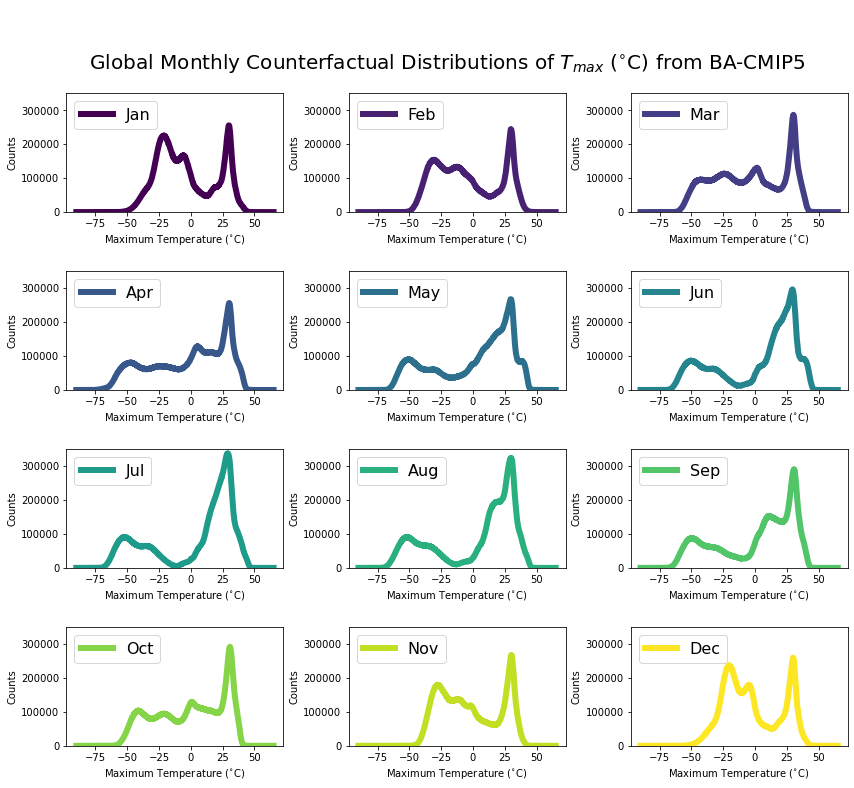

In [10]:
# set up the plot
fig=plt.figure(figsize=(14,12))

# loop over the months
for mi in months:
    
    # load each month's pooled data
    mon_zarrname='pooledCF_mon'+str(mi).zfill(2)+'.zarr'
    ds_in=util.load_zarr_local(pooled_savepath,mon_zarrname)
    # grab the CF distribution we need
    CF_mi=ds_in[pooledvarname].load()
    del ds_in
    
    ## PLOT
    # get the subplot
    plt.subplot(4,3,mi)
    
    # plot the distribution
    plt.plot(CF_mi[binkey],CF_mi.sum({'lat','lon'}).squeeze(),lw=6, \
             color=cols_mon[mi-1],label=monnames[mi-1])
    
    # set other aspects of the plot
    plt.xlabel('Maximum Temperature ($^{\circ}$C)')
    plt.ylabel('Counts')
    plt.legend(loc='upper left',fontsize=16)
    plt.ylim([0,350000])
    del CF_mi

fig.subplots_adjust(wspace=0.3,hspace=0.5)
fig.suptitle('\n\n Global Monthly Counterfactual Distributions of $T_{max}$ ($^{\circ}$C) from BA-CMIP5',fontsize=20)
plt.show()

## Phoenix in July: Model Natural Distributions vs. Pooled CF distribution

To show how the pooling might express itself in a given location, we use our example city (Phoenix, AZ, USA) to look at the maximum temperature distributions of each individual natural model, and compare those to the pooled counterfactual distribution.

Rather than plot a raw histogram of each distribution, we want to visualize the distributions smoothly. So we apply a kernel density estimate to a set of values resampled from the underlying raw distribution.

In [11]:
# define the bins to analyze the distributions over with KDE
kwidth=0.25
kbins=np.arange(minnat,maxnat+kwidth,kwidth)

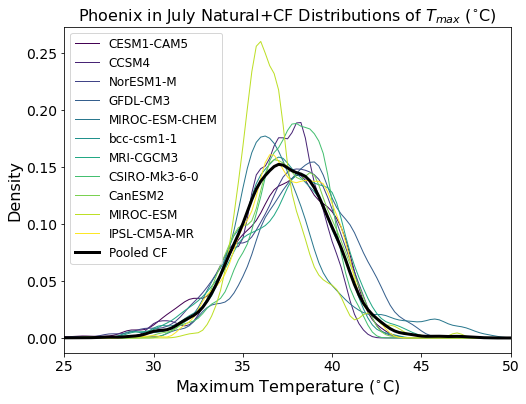

In [12]:
# set up the plot
plt.figure(figsize=(8,6))
cols_models=cmap(np.linspace(0,1,nmodel))

# load the example month's pooled data
mon_zarrname='pooledCF_mon'+str(eg_month).zfill(2)+'.zarr'
ds_in=util.load_zarr_local(pooled_savepath,mon_zarrname)
dist_pooled=ds_in[pooledvarname].sel(lon=eg_loc[0],lat=eg_loc[1],method='nearest').load()
# randomly sample the distribution
pooled_values=util.randomly_sample_histogram(dist_pooled,bins=dist_pooled[binkey])
# calculate a kernel density estimation for the resampled pooled distribution
pooled_kde=gaussian_kde(pooled_values.values,bw_method='silverman')

# loop over the models 
for ki,mname in enumerate(modelnames):
    
    # isolate this particular model's distribution at the example location
    dist_ki=ds_in[mname].sel(lon=eg_loc[0],lat=eg_loc[1],method='nearest').load()
    
    # resample the distributions
    resampled_ki=util.randomly_sample_histogram(dist_ki,bins=dist_ki[binkey])
    
    # calculate a kernel density estimation for the model's distribution
    ki_kde=gaussian_kde(resampled_ki.values,bw_method='silverman')
    
    # plot the result
    plt.plot(kbins,ki_kde(kbins),lw=1,color=cols_models[ki],label=mname)
    
# plot the pooled results
plt.plot(kbins,pooled_kde(kbins),lw=3,color='k',label='Pooled CF')
    
# set other aspects of the plot
plt.xlabel('Maximum Temperature ($^{\circ}$C)',fontsize=16)
plt.ylabel('Density',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([25,50])
plt.legend(loc='upper left',fontsize=12)
plt.title('Phoenix in July Natural+CF Distributions of $T_{max}$ ($^{\circ}$C)',fontsize=16)

plt.show()

Note that this resampling method is likewise applied in combination with the saved pooled histograms (with a given high precision, see above) to determine CF values used in the attribution statistics. We explore the sensitivity of this resampling approach in [CMIP5_resample_CF.ipynb](./CMIP5_resample_CF.ipynb).

# Find Stabilized Quantiles from Resampling of Natural Distributions

Let's check the quantiles from the maximum temperature distribution across all geolocations and see how sensitive they are to our resampling technique. There is a certain of number of samples that will provide stability to recreating the underlying sample. We check the see whether the quantile estimate converges...

In [13]:
# define the array giving the number of (re)samples to take
nsamps=[1e3,1e4,1e5,2e5,3e5,1e6,1e7]
# define the quantiles to check
qcheck=[0.5,0.75,0.9,0.95,0.975,0.99]

# initialize the array we will store the results in
qvals=np.zeros((len(nsamps),len(qcheck)),dtype='float64')

# group all of the values together across the range of latitudes/longitudes to resample
array_to_resample=ds_in[pooledvarname].sum({'lat','lon'}).squeeze().load()

# loop over the different sets of resampling N-values
for i,n in enumerate(nsamps):
    
    # tell the user how many samples we are currently testing
    print(int(n))
    
    # resample the pooled distribution with the new N
    poolcheck=util.randomly_sample_histogram(array_to_resample.values,N=int(n),
                                        bins=array_to_resample[binkey])

    # calculate the quantiles from the resampled set of values
    qvals[i,:]=poolcheck.quantile(qcheck)


1000
10000
100000
200000
300000
1000000
10000000


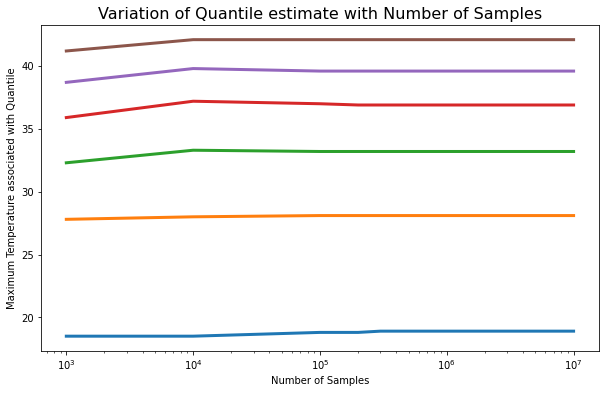

In [14]:
# plot the results, and and ensure the values converge to a single number
plt.figure(figsize=(10,6))
plt.semilogx(nsamps,qvals,lw=3)
plt.xlabel('Number of Samples')
plt.ylabel('Maximum Temperature associated with Quantile')
plt.title('Variation of Quantile estimate with Number of Samples',fontsize=16)
plt.show()

In [15]:
print(np.round(np.diff(qvals,axis=0),3))

[[ 0.     0.2    1.     1.3    1.097  0.9  ]
 [ 0.3    0.1   -0.1   -0.2   -0.2    0.   ]
 [ 0.     0.     0.    -0.1    0.     0.   ]
 [ 0.1    0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.   ]]


The quantile values converge after ~2e5 (two hundred thousand) samples to the order of our precision (which is higher than the precision of the query observations). This implies that the sampling method uses a large enough number to reproduce the quantities of the underlying distribution, at large scale for the whole domain. At smaller scale or a given geolocation with fewer outcomes/smaller maximum temperature range than the whole domain, we would expect this resampling to converge faster.

Accordingly, this method is used going forward in our attribution analyses with ```N=200_000``` samples.

# Create Single Pooled Counterfactual Output File

We have created a set of pooled counterfactual distributions and stored them alongside each model's bias-adjusted natural distribution, which enables comparison, etc. in this notebook.

Next, let's create a single file that has stores a resampled set of values from the pooled counterfactual distribution, for use throughout the remainder of our attribution analysis.

In [7]:
# define the number of samples we will take at each location,
# given the sensitivity found above:
N=200_000

In [8]:
import s3fs
import zarr
s3 = s3fs.S3FileSystem()

In [9]:
# loop over the months
for mi in months:
    
    # load each month's pooled data
    mon_zarrname='pooledCF_mon'+str(mi).zfill(2)+'.zarr'
    ds_mi=util.load_zarr_local(pooled_savepath,mon_zarrname)
    # grab the CF distribution we need
    CF_pooled=ds_mi[pooledvarname].load()
    del ds_mi
    GET THE NAME OF THE VARIABLE, USE THAT TO ENCODE
    dsaas
    
    # resample the distribution over space N times
    CF_resample=xr.apply_ufunc(
                util.randomly_sample_histogram,
                CF_pooled,
                kwargs=dict(N=N,bins=CF_pooled[binkey]),
                input_core_dims=[
                    [binkey],
                ],
                output_core_dims=[
                    ['samples'],
                ],
                vectorize=True
            )
    
    # store the result
    store = s3fs.S3Map(root='s3://gridded-data-dev/CMIP5_resample/'+monzarr,
                       s3=s3fs.S3FileSystem(), check=False)
    encoding = {vname: {'compressor':zarr.Blosc(cname='zstd', clevel=3)}
                for vname in CF_resample.data_vars}
    CF_resample.to_zarr(store=store, encoding=encoding, consolidated=True, mode='w')
    
    # clean up
    del CF_pooled, CF_resample
    
    # tell the user where we are
    print('Completed resampling, month=='+str(mi))


NameError: name 'pooledvarname' is not defined